## Tensorflow based Pos reconstruction in XENON1T

  * Yuehuan and Fei

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import pickle
import numpy.random as rnd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from tqdm import tqdm
path = '/home/feigao/machinelearning/tensorflow/data/'



## Using Keras

In [2]:
# Libs for Keras 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Reshape, Flatten
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.layers import Input, Conv1D, GlobalMaxPooling1D, Convolution2D, GlobalMaxPooling2D
from keras.preprocessing import sequence
from keras.models import model_from_json

Using TensorFlow backend.


In [3]:
## Try to control memory usage, if you have two more people sharing same GPU, like Chris and me.
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.42
set_session(tf.Session(config=config))

In [24]:
def save_model(your_model, name='your_model'):
    model_json = your_model.to_json()
    path='./trained_models/'
    # Saving our model to Jason file for later use
    with open(path+name+'.json', "w") as json_file:
        json_file.write(model_json)
    your_model.save_weights(path+name+'.h5')
    print("Saved model to disk:", name)

##
def load_model(name='your_model'):
    # load json and create model
    path='./trained_models/'

    json_file = open(path+name+'.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(path+name+'.h5')
    print("Loaded model from disk:",name)
    # evaluate loaded model on test data
    loaded_model.compile(loss='mean_squared_error', optimizer='adam')
    return loaded_model

## Reconstruct X,Y using PMT hit pattern

In [ ]:
### Loading FAX simulated data frames
df_1 = pd.read_pickle(path+'pos_df_2e5_training.pkl')
df_2 = pd.read_pickle(path+'pos_df_7e5_training.pkl')
df_pos = pd.concat([df_1,df_2])

In [ ]:
df_pos.head(5)

In [ ]:
pmthits = df_pos.loc[:,[c for c in df_pos.columns if 'PMT' in c]].values
list_bad_pmts = [1, 2, 12, 26, 34, 62, 65, 79, 86, 88, 102, 118, 130, 134, 135, 139, 148, 150, 152, 162, 178, 183, 190, 198, 206, 213, 214, 234, 239, 244]
pmthits_clean = df_pos.loc[:,[c for i, c in enumerate(df_pos.columns) if 'PMT' in c and i not in list_bad_pmts]].values
s2top = df_pos['s2top'].values
target = df_pos[['xp','yp']].values

offset = 1e-5
for i in range(len(pmthits)):
    pmthits[i] /= s2top[i] 
    pmthits_clean[i] /= s2top[i]

pmthits[np.isnan(pmthits)] = 0
pmthits_clean[np.isnan(pmthits_clean)] = 0
pmthits += offset
pmthits_clean += offset

In [ ]:
pmthits[0].sum() # Check whether normalization is done

In [ ]:
## Training samples without removing not working PMTs
test_size = 800000
remaining_size = len(pmthits_clean) - test_size
batch_size = 1000
epochs = 20
x_train_pos = pmthits_clean[:test_size]
y_train_pos = target[:test_size]
x_test_pos = pmthits_clean[:-test_size]
y_test_pos = target[:-test_size]

In [ ]:
# define the model
def MLP(activation='elu', 
        reg_scale=0.01, # Regularization on coefficients
        keep_rate=0.2,  # The smaller the keep rate, the better the performance is
        noutput=2):
    
    # parameters
    hidden = [100,80,60] # hidden layers to use, for reference, Yuehuan used [32,28]
    # create sequential model
    model = Sequential() 
    model.add(Dense(len(x_train_pos[0]), input_dim=len(x_train_pos[0]))) # Input layer
    for hid in hidden:
        model.add(Dense(hid, kernel_initializer='normal', activation=activation, bias_initializer='zeros', use_bias=True, kernel_regularizer = regularizers.l2(reg_scale)))
        model.add(Dropout(keep_rate))
    model.add(Dense(noutput)) # Output layer
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [ ]:
mlp_model = MLP() #KerasRegressor(build_fn=MLP, epochs=10, batch_size=50, verbose=1)
mlp_model.summary()
mpl_model.fit(x_train_pos, y_train_pos, batch_size=batch_size, validation_split=0.1, epochs=epochs, verbose=1)

In [ ]:
save_model(test_model,'mpl_model')
mlp = load_model('mpl_model')

In [ ]:
y_pred_te = mlp.predict(x_test_pos)
y_pred_tr = mlp.predict(x_train_pos)

In [ ]:
plt.hist(np.sqrt((y_pred_tr[:,0]-y_train_pos[:,0])**2+(y_pred_tr[:,1]-y_train_pos[:,1])**2),bins=200,normed=True, range=(0,20), alpha=0.7, label='Training sample')
plt.hist(np.sqrt((y_pred_te[:,0]-y_test_pos[:,0])**2+(y_pred_te[:,1]-y_test_pos[:,1])**2),bins=200,normed=True, range=(0,20), alpha=0.4, label='Test sample')

plt.legend()
plt.xlabel('${\Delta}$R [cm]')
plt.xlim(0,10)
plt.show()

In [ ]:
plt.hist(y_pred_tr[:,0]-y_train_pos[:,0],bins=200,normed=True, range=(-10,10), alpha=0.7, label='Training sample')
plt.hist(y_pred_te[:,0]-y_test_pos[:,0],bins=200,normed=True, range=(-10,10), alpha=0.4, label='Test sample')

plt.legend()
#plt.yscale('log')
plt.xlabel('${\Delta}$X [cm]')
plt.xlim(-10,10)
plt.show()

In [ ]:
test = plt.hist(y_pred_tr[:,1]-y_train_pos[:,1],bins=200,normed=True, range=(-10,10), alpha=0.7, label='Training sample')
plt.hist(y_pred_te[:,1]-y_test_pos[:,1],bins=200,normed=True, range=(-10,10), alpha=0.3, label='Test sample')

plt.legend()
#plt.yscale('log')
plt.xlabel('${\Delta}$Y [cm]')
plt.xlim(-10,10)
plt.show()

## Convolutional NN, reconstruct Z using S2 pulse shape

In [6]:
## Loading Tianyu's simulated WF
nfiles=500

pkls = []
for i in tqdm(range(nfiles)):
    # print('reading file',i)
    pkls.append(pd.read_pickle(path+'merged/'+'S2_Sum_Waveform_F10_{:06}.pkl'.format(i)))
df_s2 = pd.concat(pkls)

100%|██████████| 500/500 [09:58<00:00,  1.20s/it]


In [7]:
df_s2 = df_s2[df_s2.s2>0]
df_s2.head(5)

,run_number,event_number,s2_sum_waveform,drift_time,largest_coincidence,largest_other_s1,largest_other_s2,largest_unknown,largest_veto,s1,...,truth_s2_hit_time_mean,truth_s2_width,truth_s2_area_fraction_top,truth_x,truth_y,truth_other_s2_n_electron,truth_other_s2,truth_other_s2_hit_time_mean,truth_other_s2_width,truth_other_s2_area_fraction_top
0,10000,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",232810.0,0,0.0,34.682091,1.797344,0,6.972067,...,237767.118192,940.864508,0.613861,26.310178,-0.910321,NaN,NaN,NaN,NaN,NaN
1,10000,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",299910.0,0,0.0,27.431744,4.021399,0,4.948143,...,303386.886408,1022.812858,0.598394,-6.382153,-15.159193,NaN,NaN,NaN,NaN,NaN
2,10000,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",597060.0,0,0.0,22.610598,0.000000,0,3.915175,...,602954.701732,745.983378,0.650442,25.367455,22.566832,NaN,NaN,NaN,NaN,NaN
3,10000,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",350990.0,0,0.0,36.266315,2.567431,0,3.272066,...,356860.755382,971.315544,0.669683,12.837165,-28.644673,NaN,NaN,NaN,NaN,NaN
4,10000,4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",397790.0,0,0.0,27.619095,0.000000,0,9.232641,...,404693.576776,828.463100,0.663265,32.787655,-23.619538,NaN,NaN,NaN,NaN,NaN


In [14]:
s2_sum_waveform = df_s2.s2_sum_waveform.values
target = df_s2['z'].values
del df_s2

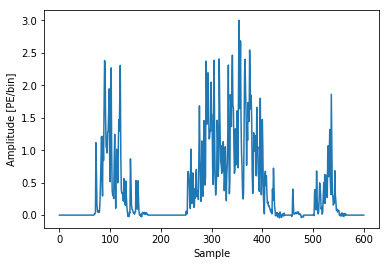

In [12]:
def draw_wf(event_id):
    plt.plot(range(len(df_s2.s2_sum_waveform.values[event_id])),df_s2.s2_sum_waveform.values[event_id])
    plt.ylabel('Amplitude [PE/bin]')
    plt.xlabel('Sample')
    plt.show()
draw_wf(20)

In [13]:
test_size = int(0.9*len(s2_sum_waveform))
batch_size = 100
epochs = 10
remaining_size = len(s2_sum_waveform) - test_size
x_train = s2_sum_waveform[:test_size]
y_train = target[:test_size] 
x_test = s2_sum_waveform[:-test_size]
y_test = target[:-test_size] 

maxlen = len(x_train[0])
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)


In [19]:
from keras.layers import Input, Conv1D, GlobalMaxPooling1D, Convolution2D

def DcNN(ngrids=25, # putting 601 WF channels into a 2-d space, 25 * 25 = 625 
         reg_scale=0.01, # Regularization on coefficients
         keeprate=0.2, # Dropout methode for regularization
         ):
    
    model = Sequential() # Sequential model from Keras
    ngrids = int(ngrids) #     
    default = {'activation' : 'elu',
              'kernel_initializer':'normal'}

    # Input Layer
    model.add(Dense(int(ngrids*ngrids),input_shape=x_train[0].shape, **default))
    model.add(Reshape((ngrids, ngrids,1,),)) # Reshaping for cNN-2D
    
    # CNN 
    cnn_filters = [80,40,20,20]
    kernel_size = [20,10,5,5]
    for i, cf in enumerate(cnn_filters):
        k_size = kernel_size[i]
        model.add(Convolution2D(cf,
                                (int(k_size), int(k_size)), 
                                padding='same', 
                                **default))

        model.add(Dropout(keeprate)) # Drop out for 

    # Flattern to Dense Fully connected nets
    model.add(Flatten())

    # MLP, Fully connected nets
    mlp_layers = [100,80,60] # hidden layers to use, for reference, Yuehuan used [32,28]
    for dense_channels in mlp_layers:
        model.add(Dense(int(dense_channels), **default))
        model.add(Dropout(keeprate))

    noutput = 1 # Number of outputs, currently set as Z
    model.add(Dense(noutput)) # Output layer                                                             
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

DcNN().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 625)               376250    
_________________________________________________________________
reshape_4 (Reshape)          (None, 25, 25, 1)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 25, 25, 80)        32080     
_________________________________________________________________
dropout_15 (Dropout)         (None, 25, 25, 80)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 25, 25, 40)        320040    
_________________________________________________________________
dropout_16 (Dropout)         (None, 25, 25, 40)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 25, 25, 20)        20020     
__________

In [20]:
dcnn_model = DcNN()
#dcnn_model.summary()
dcnn_model.fit(x_train, y_train, batch_size=batch_size, validation_split=0.1, epochs=epochs, verbose=1) #((result - y_train)**2).sum()

Train on 297344 samples, validate on 33039 samples
Epoch 1/10
297344/297344 [==============================] - 174s - loss: 413.7784 - val_loss: 348.2792
Epoch 2/10
297344/297344 [==============================] - 173s - loss: 376.8235 - val_loss: 339.7615
Epoch 3/10
297344/297344 [==============================] - 172s - loss: 1534189.9901 - val_loss: 502.791015
Epoch 4/10
297344/297344 [==============================] - 171s - loss: 439.6559 - val_loss: 392.4152
Epoch 5/10
297344/297344 [==============================] - 163s - loss: 398.2221 - val_loss: 379.3705
Epoch 6/10
297344/297344 [==============================] - 172s - loss: 381.5506 - val_loss: 349.1099
Epoch 7/10
297344/297344 [==============================] - 172s - loss: 376.1307 - val_loss: 353.8069
Epoch 8/10
297344/297344 [==============================] - 172s - loss: 367.6137 - val_loss: 347.2232
Epoch 9/10
297344/297344 [==============================] - 172s - loss: 366.0054 - val_loss: 362.4799
Epoch 10/10
2973

In [25]:
save_model(dcnn_model,'dcnn_model')
dcnn_model = load_model('dcnn_model')

Saved model to disk: dcnn_model
Loaded model from disk: dcnn_model


In [26]:
y_pred_te = dcnn_model.predict(x_test)
y_pred_tr = dcnn_model.predict(x_train)

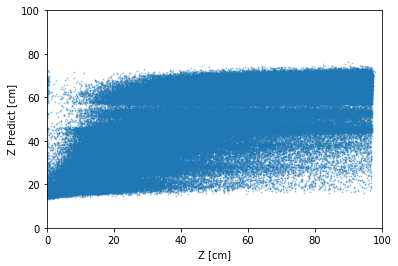

In [27]:
plt.scatter(-y_train, -y_pred_tr,alpha=0.3, label='Training sample',s=1)
#plt.yscale('log')
plt.xlabel('Z [cm]')
plt.ylabel('Z Predict [cm]')

plt.xlim(0,100)
plt.ylim(0,100)

plt.show()

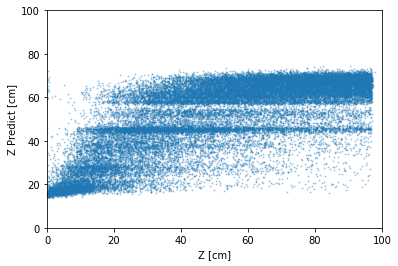

In [28]:
plt.scatter(-y_test, -y_pred_te,alpha=0.3, label='Training sample',s=1)
#plt.yscale('log')
plt.xlabel('Z [cm]')
plt.ylabel('Z Predict [cm]')

plt.xlim(0,100)
plt.ylim(0,100)

plt.show()